In [126]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [128]:
from src.activation_functions import *
from src.loss_functions import *
from src.random_search import *
from src.batch_normalization import *
from src.layer import *
from src.early_stopping import *
from src.utils import *
from src.optimizers import *
import itertools
import pandas as pd
import numpy as np
import sys
import os


In [129]:
df_path = "../ML_project/data/cup/ML-CUP24-TR.csv"
df_path2 = "../ML_project/data/cup/ML-CUP24-TS.csv"

# Preview the dataset
df = pd.read_csv(df_path, skiprows=7, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0.946373,0.307995,0.820058,-0.309386,0.950936,-0.000913,-0.093048,-0.029318,0.995230,-1.175176,2.295016,0.223732,-0.011599,-0.503652,-5.564158
1,2,-0.074075,-0.992654,-1.162582,0.997240,-0.074209,-0.002159,-0.004956,-0.095561,0.995411,0.675930,3.147029,-0.297508,-0.361982,-0.186246,3.445744
2,3,0.841384,0.531605,0.810176,-0.534053,0.845451,-0.001057,-0.082832,-0.051079,0.995254,-1.069958,2.415989,0.234664,0.170027,-0.344143,-3.675575
3,4,0.737117,-0.668400,-1.065601,0.671734,0.740793,0.000008,0.073704,-0.066844,0.995038,11.038418,1.003455,-0.100332,-1.032355,-1.184874,15.554511
4,5,-0.987858,-0.119426,-1.072857,0.120013,-0.992772,0.000064,-0.098661,-0.011863,0.995050,14.834930,1.127759,-0.112600,-0.134817,2.047468,20.522760


In [130]:
df.columns = ["ID"] + [f'input_{i}' for i in range(12)] + ['target_x', 'target_y', 'target_z']
df = df.drop("ID", axis=1)

In [131]:
X_train, X_val, y_train, y_val, X_scaler, y_scaler = preprocess_data(
    df, 
    target=["target_x", "target_y", "target_z"],
    normalize_type="z-score",
    val_ratio=0.2,
    regression=True
)

In [132]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((200, 12), (200, 3), (50, 12), (50, 3))

In [133]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [134]:
param_distributions = {
    'hidden_size': [[3], [4], [5], [6]],
    'hidden_activation': [[Activation_Tanh], [Activation_Leaky_ReLU], [Activation_Sigmoid], [Activation_ReLU]],
    'batch_norm': [[False]],
    'learning_rate': np.logspace(-3, -1, num=20).tolist(),
    'l1':  np.logspace(-5, -1, num=10).tolist(),
    'l2': np.logspace(-5, -1, num=10).tolist(),
    'dropout_rate': np.logspace(-5, -1, num=10).tolist(),
    'batch_size': [8, 16, 32],
    'n_epochs': [50,100],
    'weight_decay': np.logspace(-5, -1, num=20).tolist(),
    'patience': [10, 30, 50]
}

In [135]:
best_hyperparams, best_performance = random_search(X_train=X_train,
                                                   y_train=y_train,
                                                   param_distributions=param_distributions,
                                                   n_iters=500, regression=True)  # adjust n_iters as needed

print(best_hyperparams)

regression k-fold:  True
[3] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.0016681005372000592] [False]
regression:  True


ValueError: operands could not be broadcast together with shapes (32,) (32,3) 

In [ ]:
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, hidden_size, hidden_activation, use_batch_norm, weight_decay, patience, validation_accuracy = best_hyperparams.values()
print(best_hyperparams)

In [ ]:
model = NN(
    l1=l1,
    l2=l2,
    input_size=12,
    hidden_sizes=hidden_size,
    output_size=3,
    hidden_activations=hidden_activation,
    dropout_rates=[dropout_rate],
    use_batch_norm=use_batch_norm
)
# model = CascadeCorrelation(input_size = 17, output_size= 1, activation=Activation_Leaky_ReLU,
#                            output_activation = Activation_Sigmoid)
batch_size = batch_size
learning_rate = learning_rate
n_epochs = n_epochs

In [ ]:
model = NN(
    l1= 0, #7.742636826811278e-05,
    l2= 0, #2.782559402207126e-07,
    input_size=12,
    hidden_sizes=[4],
    output_size=3,
    hidden_activations=[Activation_Sigmoid],
    dropout_rates=[0],
    use_batch_norm=[True]
)
# model = CascadeCorrelation(input_size = 17, output_size= 1, activation=Activation_Leaky_ReLU,
#                            output_activation = Activation_Sigmoid)
batch_size = 1
learning_rate = 0.003
n_epochs = 100
weight_decay = 0

[4] [<class 'src.activation_functions.Activation_Sigmoid'>] [0] [True]


Data shapes:
X_train: (200, 12), y_train: (200, 3)
Epoch 0: Train Loss: nan, R²: nan | Val Loss: nan, R²: nan
Epoch 10: Train Loss: nan, R²: nan | Val Loss: nan, R²: nan
Epoch 20: Train Loss: nan, R²: nan | Val Loss: nan, R²: nan
Early stopping at epoch 29
Restoring model weights from epoch 0
Weights not restored
Final Validation R² Score: nan


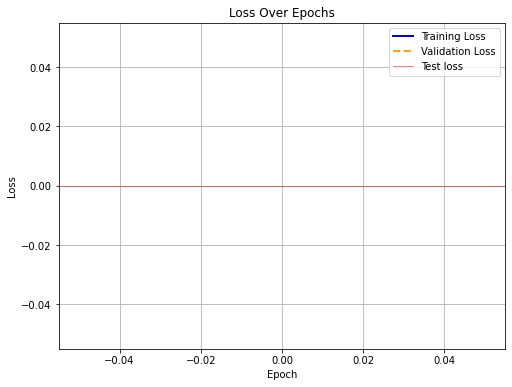

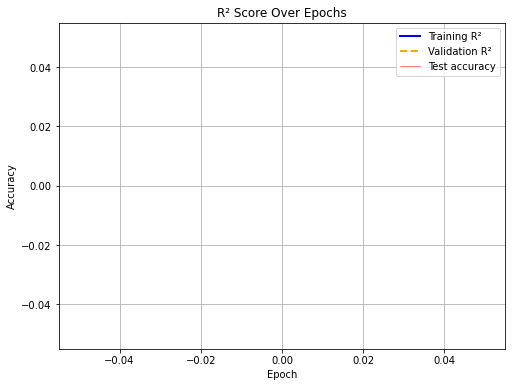

In [ ]:
train_losses = []
train_r2_scores = []
val_losses = []
val_r2_scores = []

loss_function = MSE()
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=weight_decay)
early_stopping = EarlyStopping(patience=30, min_delta_loss=1e-5, min_delta_accuracy=0.001)

print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"Hyperparams: {best_hyperparams}")

for epoch in range(n_epochs):
    batch_losses = []
    batch_r2 = []

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        model.forward(X_batch, training=True)

        loss = loss_function.forward(model.output, y_batch)
        r2 = r2_score_global(y_batch, model.output)
        
        loss_function.backward(model.output, y_batch)
        dvalues = loss_function.dinputs

        for layer in reversed(model.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs

        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()

        batch_losses.append(loss)
        batch_r2.append(r2)

    epoch_loss = np.mean(batch_losses)
    epoch_r2 = np.mean(batch_r2)
    train_losses.append(epoch_loss)
    train_r2_scores.append(epoch_r2)

    # Validation
    X_val_input = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
    y_val_input = y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val

    model.forward(X_val_input, training=False)
    val_loss = loss_function.forward(model.output, y_val_input)
    val_r2 = r2_score(y_val_input, model.output)

    val_losses.append(val_loss)
    val_r2_scores.append(val_r2)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: ", end="")
        print(f"Train Loss: {epoch_loss:.4f}, R²: {epoch_r2:.4f} | ", end="")
        print(f"Val Loss: {val_loss:.4f}, R²: {val_r2:.4f}")

    early_stopping.on_epoch_end(
        current_loss=val_loss,
        current_accuracy=val_r2,  # misnamed arg, still works internally
        model=model,
        epoch=epoch
    )

    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        print(f"Restoring model weights from epoch {early_stopping.best_epoch}")
        early_stopping.restore_weights(model)
        if isinstance(model, CascadeCorrelation):
            if model.is_limit_reached():
                break
            model.add_neuron()
            early_stopping.wait = 0
            early_stopping.patience -= int(early_stopping.patience / 10)
            early_stopping.stop_training = False
            print(f"Added new neuron at epoch {epoch} with val_loss {val_losses[-1]:.4f}")
            continue
        break

# Final evaluation
model.forward(X_val_input, training=False)
final_val_loss = loss_function.forward(model.output, y_val_input)
final_val_r2 = r2_score(y_val_input, model.output)
print(f"Final Validation R² Score: {final_val_r2:.4f}")

# Plot training progress
plot_losses(train_losses, val_losses, 0,
            label1="Training Loss", label2="Validation Loss",
            title="Loss Over Epochs")

plot_accuracies(train_r2_scores, val_r2_scores, final_val_r2,
                label1="Training R²", label2="Validation R²",
                title="R² Score Over Epochs")